# Optimal Frenet Path Planning

In [12]:
import numpy as np

In [13]:
# Way points
way_points_x = [00.0, 20.0, 30.0, 50.0]
way_points_y = [00.0, 00.75, 2.15, 03.0]


way_points_x = [00.0, 20.0, 30.0, 50.0];
way_points_y = [00.0, 00.5, 04.5, 07.0];

In [14]:
## Define Obstacles

In [46]:
objects = np.array([[10.0, -0.5],
           [15.0, 2.0],
           [20.0, 0.0],
           [30.0, 3.0],
           [45.0, 3.5]])

In [47]:
objects

array([[10. , -0.5],
       [15. ,  2. ],
       [20. ,  0. ],
       [30. ,  3. ],
       [45. ,  3.5]])

In [48]:
## Create a reference path

In [96]:
import cubic_spline_planner as csp

def calc_spline_course(x, y, ds=0.1):
    sp = csp.CubicSpline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))
    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))
    return rx, ry, ryaw, rk, s

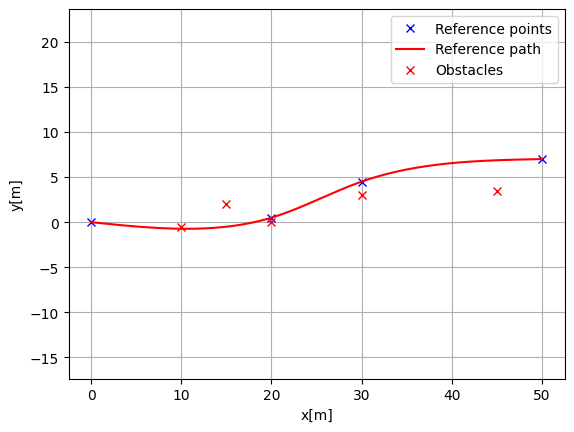

In [97]:
ref_path_x, ref_path_y, ref_path_yaw, ref_path_k, ref_path_s = calc_spline_course(way_points_x, way_points_y)

## Plot the reference path
import matplotlib.pyplot as plt
 
plt.subplots(1)
plt.plot(way_points_x, way_points_y, "xb", label="Reference points")
plt.plot(ref_path_x, ref_path_y, "-r", label="Reference path")
plt.plot(objects[:,0], objects[:,1], "xr", label="Obstacles")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()



In [51]:
# lambda function for object bounding box
obj_bbox = lambda ox, oy: np.array([[ox-1, oy+1],
        [ox-1, oy+0.5],
        [ox-1, oy],
        [ox-1, oy-0.5],
        [ox-1, oy-1],
        [ox, oy-1],
        [ox+1, oy-1],
        [ox+2, oy-1],
        [ox+3, oy-1],
        [ox+3, oy-0.5],
        [ox+3, oy],
        [ox+3, oy+0.5],
        [ox+3, oy+1],
        [ox+2, oy+1],
        [ox+1, oy+1],
        [ox, oy+1],
        [ox-1, oy+1]])

In [52]:
obj_bbox(10, 0)

array([[ 9. ,  1. ],
       [ 9. ,  0.5],
       [ 9. ,  0. ],
       [ 9. , -0.5],
       [ 9. , -1. ],
       [10. , -1. ],
       [11. , -1. ],
       [12. , -1. ],
       [13. , -1. ],
       [13. , -0.5],
       [13. ,  0. ],
       [13. ,  0.5],
       [13. ,  1. ],
       [12. ,  1. ],
       [11. ,  1. ],
       [10. ,  1. ],
       [ 9. ,  1. ]])

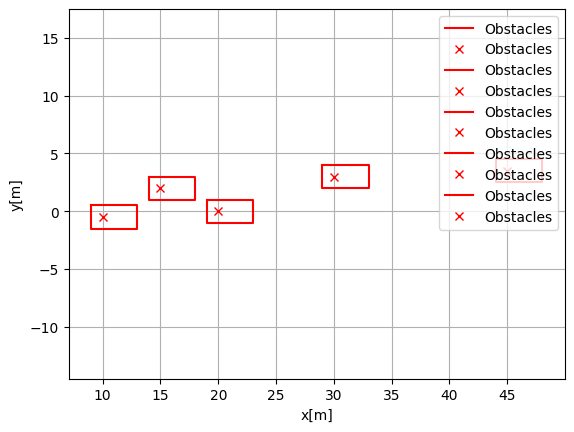

In [53]:
for i in range(len(objects)):
    obj_x, obj_y = objects[i,0], objects[i,1]
    plt.plot(obj_bbox(obj_x, obj_y)[:,0], obj_bbox(obj_x, obj_y)[:,1], "-r", label="Obstacles")
    plt.plot(obj_x, obj_y, "xr", label="Obstacles")

plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()


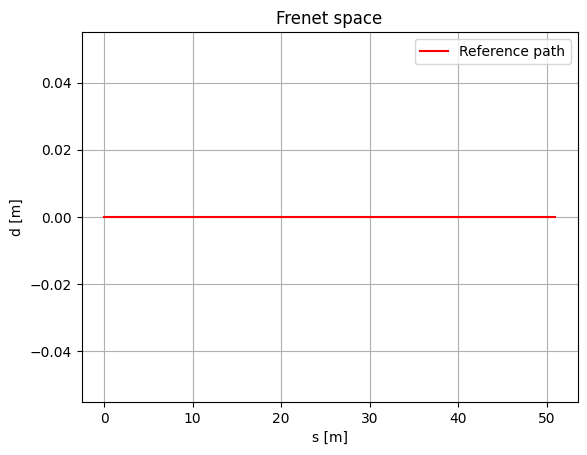

In [23]:
# Plot frenet space
plt.subplots(1)
ref_path_run_length = ref_path_s[-1]
plt.plot([0, ref_path_run_length], [0, 0], "-r", label="Reference path")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("d [m]")
plt.title("Frenet space")
plt.legend()


In [24]:
# TODO delete
def calc_global_paths(fplist, csp):

    for fp in fplist:

        # calc global positions
        for i in range(len(fp.s)):
            ix, iy = csp.calc_position(fp.s[i])
            if ix is None:
                break
            iyaw = csp.calc_yaw(fp.s[i])
            di = fp.d[i]
            fx = ix + di * math.cos(iyaw + math.pi / 2.0)
            fy = iy + di * math.sin(iyaw + math.pi / 2.0)
            fp.x.append(fx)
            fp.y.append(fy)

        # calc yaw and ds
        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(math.atan2(dy, dx))
            fp.ds.append(math.sqrt(dx**2 + dy**2))

        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            fp.c.append((fp.yaw[i + 1] - fp.yaw[i]) / fp.ds[i])

    return fplist

In [25]:
import numpy as np

def distance(x0, y0, x1, y1):
    return np.sqrt((x0 - x1)**2 + (y0 - y1)**2)

In [26]:
# TODO Delete
def cartesian_to_frenet(x, y, yaw, rx, ry):
    # Shift to local coordinate
    shift_x = [ix - x for ix in rx]
    shift_y = [iy - y for iy in ry]

    # Rotate to local coordinate
    shift_yaw = [iyaw - yaw for iyaw in ryaw]

    # Calculate frenet coordinate
    shift_s = [0.0]
    shift_d = [0.0]
    for i in range(len(shift_x)-1):
        shift_s.append(shift_s[i] + np.hypot(shift_x[i+1], shift_y[i+1]))
        shift_d.append(np.cross([shift_x[i], shift_y[i]], [np.cos(shift_yaw[i]), np.sin(shift_yaw[i])]))

    return shift_s, shift_d

def _closest_ref_points(x, y, ref_path_x, ref_path_y):
    closest_dist = float("inf")
    closest_ref_point_idx = 0

    for i in range(len(ref_path_x)):
        ref_x = ref_path_x[i]
        ref_y = ref_path_y[i]

        dist = distance(x, y, ref_x, ref_y)

        if dist < closest_dist:
            closest_dist = dist
            closest_ref_point_idx = i
        else:
            break

    # Define 2nd closes ref point index
    # Handle edge cases
    if closest_ref_point_idx == len(ref_path_x):
        closest_2nd_ref_point_idx = closest_ref_point_idx - 1
    elif closest_ref_point_idx == 1:
        closest_2nd_ref_point_idx = closest_ref_point_idx + 1
    else: # Handle default case
        ref_x_p1 = ref_path_x[closest_ref_point_idx + 1]
        ref_y_p1 = ref_path_y[closest_ref_point_idx + 1]
        dist_p1 = distance(x, y, ref_x_p1, ref_y_p1)

        ref_x_m1 = ref_path_x[closest_ref_point_idx - 1]
        ref_y_m1 = ref_path_y[closest_ref_point_idx - 1]
        dist_m1 = distance(x, y, ref_x_m1, ref_y_m1)

        if dist_p1 < dist_m1:
            closest_2nd_ref_point_idx = closest_ref_point_idx + 1
        else:
            closest_2nd_ref_point_idx = closest_ref_point_idx - 1

    return closest_ref_point_idx, closest_2nd_ref_point_idx


def cartesian_to_frenet(x, y, yaw, ref_path_x, ref_path_y):
    # Find closest ref points
    closest_ref_point_idx, closest_2nd_ref_point_idx = _closest_ref_points(x, y, ref_path_x, ref_path_y)

    if closest_ref_point_idx > closest_2nd_ref_point_idx:
        next_ref_point_idx = closest_ref_point_idx
    else:
        next_ref_point_idx = closest_2nd_ref_point_idx

    prev_ref_point_idx = next_ref_point_idx - 1
    if next_ref_point_idx == 0:
        prev_ref_point_idx = 0
        next_ref_point_idx = 1

    tangent_x = ref_path_x[next_ref_point_idx] - ref_path_x[prev_ref_point_idx]
    tangent_y = ref_path_y[next_ref_point_idx] - ref_path_y[prev_ref_point_idx]

    #qTangent = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fTangentX, fTangentY, 0);

    vec_x = x - ref_path_x[prev_ref_point_idx]
    vec_y = y - ref_path_y[prev_ref_point_idx]

    #qVec = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fVecX, fVecY, 0);
    
    # Find the projection of vec onto tangential vector
    #projected_vec_norm = (vec_x * tangent_x + vec_y * tangent_y) / (tangent_x * tangent_x + tangent_y * tangent_y)
    #projected_vec_norm = (vec_x * tangent_x + vec_y * tangent_y) / math.sqrt(tangent_x * tangent_x + tangent_y * tangent_y)

    tangent_length = math.sqrt(tangent_x * tangent_x + tangent_y * tangent_y)
    projected_vec_norm =  np.dot([vec_x, vec_y], [tangent_x, tangent_y]) / tangent_length

    projected_vec_x = projected_vec_norm * tangent_x / tangent_length
    projected_vec_y = projected_vec_norm * tangent_y / tangent_length


    #qProjectedVec = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fProjectedVecX, fProjectedVecY, 0);

    # Calculate frenet coordinate
    #frenet_d = np.cross([vec_x, vec_y], [tangent_x, tangent_y]) / tangent_length

    frenet_d = distance(vec_x, vec_y, projected_vec_x, projected_vec_y)

    # Check if d value is positive or negative using the dot product result
    x0 = ref_path_x[prev_ref_point_idx]
    y0 = ref_path_y[prev_ref_point_idx]
    x1 = ref_path_x[next_ref_point_idx]
    y1 = ref_path_y[next_ref_point_idx]

    # why negative?
    d = (x - x0) * (y1 - y0) - (y - y0) * (x1 - x0)
    d2 = np.dot([x - x0, y - y0], [y1 - y0, -(x1 - x0)])

    side = np.sign(d)
    side2 = np.sign(d2)

    if side > 0:
        frenet_d = -frenet_d


    # Calculate frenet s coordinate
    frenet_s = 0
    for i in range(prev_ref_point_idx):
        frenet_s += distance(ref_path_x[i], ref_path_y[i], ref_path_x[i+1], ref_path_y[i+1])

    frenet_s2 = frenet_s    
    frenet_s += projected_vec_norm
    frenet_s2 = distance(0, 0, projected_vec_x, projected_vec_y)

    return frenet_s, frenet_d


(0.0, 0.0)

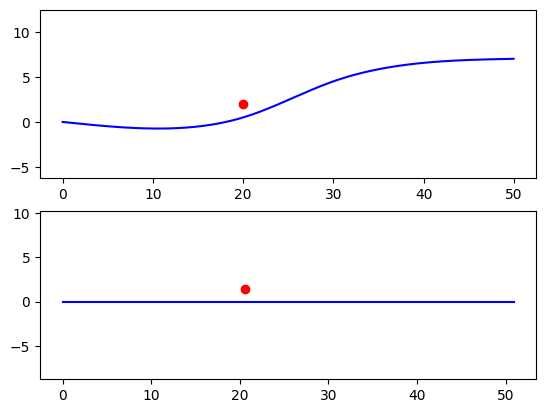

In [99]:
x = 20
y = 2
frenet_s, frenet_d = cartesian_to_frenet(x, y, 0, ref_path_x, ref_path_y)

# subplots for cartesian and frenet coordinates
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ref_path_x, ref_path_y, 'b-')
ax1.plot(x, y, 'ro')
ax1.axis('equal')

ref_path_run_length = ref_path_s[-1]
ref_path_s_start_end = [0, ref_path_run_length]
ref_path_d = [0, 0]
ax2.plot(ref_path_s_start_end, ref_path_d, 'b-', label='Reference path')
ax2.plot(frenet_s, frenet_d, 'ro')
ax2.axis('equal')
plt.show()

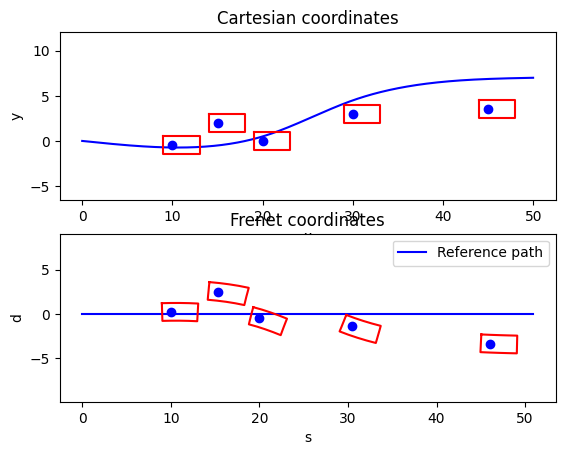

In [100]:
# Plot objects including bounding boxes
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(ref_path_x, ref_path_y, 'b-')
ax1.axis('equal')

ref_path_run_length = ref_path_s[-1]
ref_path_s_start_end = [0, ref_path_run_length]
ref_path_d = [0, 0]
ax2.plot(ref_path_s_start_end, ref_path_d, 'b-', label='Reference path')
ax2.axis('equal')

objects = np.array([[10.0, -0.5],
           [15.0, 2.0],
           [20.0, 0.0],
           [30.0, 3.0],
           [45.0, 3.5]])


for i in range(len(objects)):
    obj = objects[i]
    obj_x = obj[0]
    obj_y = obj[1]
    obj_s, obj_d = cartesian_to_frenet(obj_x, obj_y, 0, ref_path_x, ref_path_y)

    ax1.plot(obj_x, obj_y, 'bo')
    ax2.plot(obj_s, obj_d, 'bo')

    # Plot bounding box using obj_bbox
    obj_box = obj_bbox(obj_x, obj_y)

    obj_points = len(obj_box)
    obj_box_s = np.zeros(obj_points)
    obj_box_d = np.zeros(obj_points)
    for j in range(obj_points):
        obj_box_s[j], obj_box_d[j] = cartesian_to_frenet(obj_box[j][0], obj_box[j][1], 0, ref_path_x, ref_path_y)

    ax1.plot(obj_box[:,0], obj_box[:,1], 'r-')
    ax2.plot(obj_box_s, obj_box_d, 'r-')

ax1.axis('equal')
ax2.axis('equal')
ax1.set_title('Cartesian coordinates')
ax2.set_title('Frenet coordinates')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_xlabel('s')
ax2.set_ylabel('d')
ax2.legend()
plt.show()
    
    
     


In [101]:
def frenet_to_cartesian(s, d, ref_path_run_length, ref_path_x, ref_path_y):
    """Convert Frenet coordinates to Cartesian coordinates"""
    next_ref_point_idx = 0

    while s > ref_path_run_length[next_ref_point_idx+1] and next_ref_point_idx < len(ref_path_run_length):
        next_ref_point_idx += 1

    prev_ref_point_idx = next_ref_point_idx - 1

    heading = np.arctan2(ref_path_y[next_ref_point_idx] - ref_path_y[prev_ref_point_idx],
                            ref_path_x[next_ref_point_idx] - ref_path_x[prev_ref_point_idx])
    
    # The x,y,s along the segment
    segment_s = s - ref_path_run_length[prev_ref_point_idx]

    segment_x = ref_path_x[prev_ref_point_idx] + segment_s * np.cos(heading)
    segment_y = ref_path_y[prev_ref_point_idx] + segment_s * np.sin(heading)

    # perpendicular heading
    perpendicular_heading = heading - np.pi / 2

    # the new x,y coordinates
    x = segment_x + d * np.sin(perpendicular_heading)
    y = segment_y - d * np.cos(perpendicular_heading)

    return x, y, heading

In [102]:
obj_x = 20.0
obj_y = 2.0

obj_s, obj_d = cartesian_to_frenet(obj_x, obj_y, 0, ref_path_x, ref_path_y)

print('obj_s = ', obj_s)
print('obj_d = ', obj_d)

obj_x2, obj_y2, obj_heading = frenet_to_cartesian(obj_s, obj_d, ref_path_s, ref_path_x, ref_path_y)

print('obj_x2 = ', obj_x2)
print('obj_y2 = ', obj_y2)



obj_s =  20.604583521801644
obj_d =  1.431543419835672
obj_x2 =  19.203730044023494
obj_y2 =  0.2347000311442683


[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2000000000000002,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.8,
 1.9000000000000001,
 2.0,
 2.1,
 2.2,
 2.3000000000000003,
 2.4000000000000004,
 2.5,
 2.6,
 2.7,
 2.8000000000000003,
 2.9000000000000004,
 3.0,
 3.1,
 3.2,
 3.3000000000000003,
 3.4000000000000004,
 3.5,
 3.6,
 3.7,
 3.8000000000000003,
 3.9000000000000004,
 4.0,
 4.1000000000000005,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6000000000000005,
 4.7,
 4.800000000000001,
 4.9,
 5.0,
 5.1000000000000005,
 5.2,
 5.300000000000001,
 5.4,
 5.5,
 5.6000000000000005,
 5.7,
 5.800000000000001,
 5.9,
 6.0,
 6.1000000000000005,
 6.2,
 6.300000000000001,
 6.4,
 6.5,
 6.6000000000000005,
 6.7,
 6.800000000000001,
 6.9,
 7.0,
 7.1000000000000005,
 7.2,
 7.300000000000001,
 7.4,
 7.5,
 7.6000000000000005,
 7.7,
 7.800000000000001,
 7.9,
 8.0,
 8.1,
 8.200000000000001,
 8.3,
 8.4,
 8.5,
 8.6,
 8.700000000000001,


In [104]:
def cart2frenet(x, y, ref_path_x, ref_path_y, ds=0.1):

    # Find the closest ref_path point
    # Concatenate X_query and Y_query into a single 2 x N array
    query = np.vstack((x, y))

    # Concatenate RefX and RefY into a single 2 x M array
    ref = np.vstack((ref_path_x, ref_path_y))

    # Compute the Euclidean distance between each column of query and each column of ref
    dists = np.linalg.norm(np.tile(query, (1, ref.shape[1])) - np.repeat(ref, query.shape[1], axis=1), axis=0)

    # Get the indices that would sort the distances in ascending order
    sort_idx = np.argsort(dists)

    # Get the index of the closest ref_path point
    closest_ref_point_idx = sort_idx[0]
    closes_2nd_ref_point_idx = sort_idx[1]

    if closest_ref_point_idx > closes_2nd_ref_point_idx:
        next_ref_point_idx = closest_ref_point_idx
    else:
        next_ref_point_idx = closes_2nd_ref_point_idx

    prev_ref_point_idx = next_ref_point_idx - 1
    if next_ref_point_idx == 0:
        prev_ref_point_idx = 0
        next_ref_point_idx = 1

    # Find intersectin point between the two points
    # Tangent line between the two points
    tangent_slope = (ref_path_y[next_ref_point_idx] - ref_path_y[prev_ref_point_idx]) / (ref_path_x[next_ref_point_idx] - ref_path_x[prev_ref_point_idx])
    tangent_intercept = ref_path_y[next_ref_point_idx] - tangent_slope * ref_path_x[next_ref_point_idx]

    # Orthogonal line from the query point to the tangent line
    orthogonal_slope = -1 / tangent_slope
    orthogonal_intercept = y - orthogonal_slope * x

    # Intersection point of tangent and orthogonal line
    intersect_point = np.linalg.inv(np.array([[-tangent_slope, 1], [-orthogonal_slope, 1]])) @ np.array([[tangent_intercept], [orthogonal_intercept]])

    # Check if d value is positive or negative using the dot product result
    x0 = ref_path_x[prev_ref_point_idx]
    y0 = ref_path_y[prev_ref_point_idx]
    x1 = ref_path_x[next_ref_point_idx]
    y1 = ref_path_y[next_ref_point_idx]

    d = np.sqrt((x - intersect_point[0])**2 + (y - intersect_point[1])**2)


    fd = (x - x0)*(y1 - y0)-(y - y0)*(x1 - x0)

    side = np.sign(fd)
    if side > 0:
        d = -d

    # Compute s value
    s = ds * (prev_ref_point_idx - 1) + np.sqrt((ref_path_x[prev_ref_point_idx] - intersect_point[0])**2 + (ref_path_y[prev_ref_point_idx] - intersect_point[1])**2)

    return s, d


In [105]:

obj_x = 20.0
obj_y = 2.0

obj_s, obj_d = cartesian_to_frenet(obj_x, obj_y, 0, ref_path_x, ref_path_y)

print('obj_s = ', obj_s)
print('obj_d = ', obj_d)

obj_x2, obj_y2, obj_heading = frenet_to_cartesian(obj_s, obj_d, ref_path_s, ref_path_x, ref_path_y)

print('obj_x2 = ', obj_x2)
print('obj_y2 = ', obj_y2)

obj_s2, obj_d2 = cart2frenet(obj_x, obj_y, ref_path_x, ref_path_y, ds=0.1)

print('obj_s2 = ', obj_s2)
print('obj_d2 = ', obj_d2)



obj_s =  20.604583521801644
obj_d =  1.431543419835672
obj_x2 =  19.203730044023494
obj_y2 =  0.2347000311442683
obj_s2 =  [20.3707274]
obj_d2 =  [1.43154342]


In [118]:
def frenet2cart(s, d, ref_path_run_length, ref_path_x, ref_path_y):
    next_ref_point_idx = 0

    while s > ref_path_run_length[next_ref_point_idx + 1] and next_ref_point_idx < len(ref_path_run_length):
        next_ref_point_idx += 1

    prev_ref_point_idx = next_ref_point_idx - 1

    heading = np.arctan2(ref_path_y[next_ref_point_idx] - ref_path_y[prev_ref_point_idx], ref_path_x[next_ref_point_idx] - ref_path_x[prev_ref_point_idx])

    # The x,y,s along the segment
    segment_s = s - ref_path_run_length[prev_ref_point_idx]
    
    segment_x = ref_path_x[prev_ref_point_idx] + segment_s * np.cos(heading)
    segment_y = ref_path_y[prev_ref_point_idx] + segment_s * np.sin(heading)

    perpendicular_heading = heading + np.pi / 2

    # the x,y,s along the frenet direction
    frenet_x = segment_x - d * np.cos(heading)
    frenet_y = segment_y - d * np.sin(heading)

    return frenet_x, frenet_y, heading

In [122]:

obj_x = 20.0
obj_y = 2.0

print('input')
print('obj_x = ', obj_x)
print('obj_y = ', obj_y)

obj_s, obj_d = cartesian_to_frenet(obj_x, obj_y, 0, ref_path_x, ref_path_y)
print('cartesian_to_frenet')
print('obj_s = ', obj_s)
print('obj_d = ', obj_d)

obj_x2, obj_y2, obj_heading = frenet_to_cartesian(obj_s, obj_d, ref_path_s, ref_path_x, ref_path_y)
print('frenet_to_cartesian')
print('obj_x2 = ', obj_x2)
print('obj_y2 = ', obj_y2)

obj_s2, obj_d2 = cart2frenet(obj_x, obj_y, ref_path_x, ref_path_y, ds=0.1)
print('cart2frenet')
print('obj_s2 = ', obj_s2)
print('obj_d2 = ', obj_d2)

obj_x3, obj_y3, obj_heading3 = frenet2cart(obj_s, obj_d, ref_path_s, ref_path_x, ref_path_y)
print('frenet2cart')
print('obj_x3 = ', obj_x3)
print('obj_y3 = ', obj_y3)


input
obj_x =  20.0
obj_y =  2.0
cartesian_to_frenet
obj_s =  20.604583521801644
obj_d =  1.431543419835672
frenet_to_cartesian
obj_x2 =  19.203730044023494
obj_y2 =  0.2347000311442683
cart2frenet
obj_s2 =  [20.3707274]
obj_d2 =  [1.43154342]
frenet2cart
obj_x3 =  19.203730044023494
obj_y3 =  0.2347000311442683
